In [1]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [2]:
# pip install konlpy

# 1. 네이버 영화 리뷰 데이터에 대한 이해와 전처리
- 전처리를 강화

In [1]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x1b402d4af10>)

In [2]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [3]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
print('훈련 샘플의 개수 :', len(train_data) ) # 훈련용 리뷰 개수 출력
print('테스트 샘플의 개수 :', len(test_data)  ) # 테스트용 리뷰 개수 출력

훈련 샘플의 개수 : 150000
테스트 샘플의 개수 : 50000


1. 중복확인

In [5]:
train_data['document'].nunique(), train_data['label'].nunique()
# 150000개 리뷰 중 146182개만 unique하다고 나오므로 중복 리뷰가 있다는 의미

(146182, 2)

In [6]:
# 특정 열에서 중복값을 찾아서 해당 값을 포함하는 행을 삭제(1개는 남기고)
train_data.drop_duplicates(subset=['document'], inplace=True)
# document 열에서 중복인 내용이 있다면 중복 제거

In [7]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


<Axes: xlabel='label'>

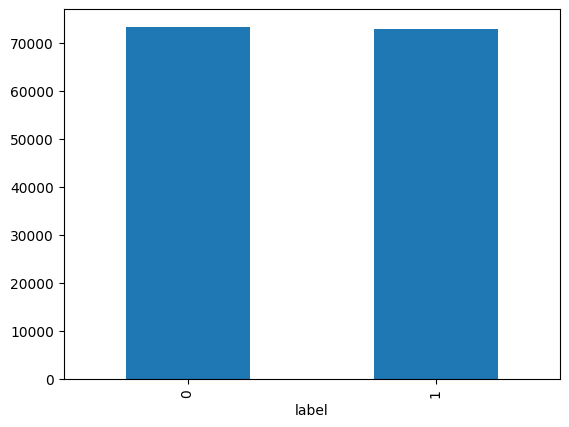

In [8]:
# 긍정리뷰 부정리뷰 비슷해보임
train_data['label'].value_counts().plot(kind='bar')

In [10]:
# 정확한 수치로 확인(부정리뷰가 약간 많음)
train_data.groupby('label').size().reset_index(name='count')

,label,count
0,0,73342
1,1,72841


2. 결측치 정리

In [14]:
# 결측치 확인
print(train_data.isnull().values.any())

True


In [15]:
# 어느 컬럼이 결측치가 있는지 확인 : document 컬럼에 결측치 있음
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [16]:
# document 컬럼에서 결측치인 컬럼 확인
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [17]:
# 결측치 행 제거
# Null 값이 존재하는 행 제거
train_data = train_data.dropna(how='any')
train_data.isnull().values.any()

False

In [18]:
print(len(train_data))

146182


3. 문자 전처리

In [21]:
import re
def temp(review) :
    return re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]','',review)

In [22]:
train_data['document'][:5].apply(temp)

0                                    아 더빙 진짜 짜증나네요 목소리
1                           흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                            교도소 이야기구먼 솔직히 재미는 없다평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
Name: document, dtype: object

In [23]:
train_data['document'] =train_data['document'].apply(temp)
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [25]:
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [28]:
# 테스트데이터 전처리
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data = test_data.dropna(how='any') # Null 값 제거

In [29]:
test_data['document'] =test_data['document'].apply(temp) # 한글과 공백 제외 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49157


In [32]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

4. 토큰화 및 stopwords 제거

In [33]:
okt = Okt()

In [34]:
X_train = []
for sentence in tqdm(train_data['document']):
    tok_sen = okt.morphs(sentence, stem=True) # 형태소 추출
    stop_rm_tok = [word for word in tok_sen if not word in stopwords] # 불용어 제거
    X_train.append(stop_rm_tok)


100%|█████████████████████████████████████████████████████████████████████████| 146182/146182 [05:02<00:00, 483.22it/s]


In [36]:
# X_train[:5]

In [88]:
test_data['document'][0]

'굳 ㅋ'

In [37]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|███████████████████████████████████████████████████████████████████████████| 49157/49157 [01:59<00:00, 412.41it/s]


In [39]:
print('전처리 후 테스트용 샘플의 개수 :',len(X_test))
print('전처리 후 학습용 샘플의 개수 :',len(X_train))

전처리 후 테스트용 샘플의 개수 : 49157
전처리 후 학습용 샘플의 개수 : 146182


### 토큰화 시간이 오래 걸리므로 임시변수 저장

In [40]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)

In [42]:
len(tokenizer.word_index)

43752

5. 토큰화된 학습 데이터 활용 단어사전 생성
- keras Tokenizer() 활용

### 단어의 등장빈도수를 활용해 등장빈도수가 낮은 단어들은 제거

In [44]:
# tokenizer.word_counts.items()

In [46]:
threshold = 3
total_cnt=len(tokenizer.word_index) # 단어수
rare_cnt=0 # 단어의 빈도수가 threshold보다 작은 단어의 수
total_freq=0 # 훈련데이터의 전체 단어 빈도수 총 합
rare_freq=0 # 등장빈도수가  threshold보다 작은 단어들의 빈도수 합

In [47]:
for key,value in tokenizer.word_counts.items() :
    total_freq = total_freq + value
    
    # 단어 각각의 빈도수가 threshold보다 작으면
    if(value < threshold) :
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [48]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [49]:
# 사용할 단어 수 결정
vocab_size = total_cnt - rare_cnt + 1
vocab_size # 단어의 출연 빈도수가 높은 (3번이상 나오는) 단어의 수
# 이 만큼만 단어사전 생성

19416

### Tokenizer(num_words)
- 단어 빈도에 따라 유지할 최대 단어 수. 가장 일반적인 단어만 보관됨
- num_words-1 만큼의 단어만 유지
- 그래서, 위 셀에서 total_cnt - rare_cnt + 1 연산 시 +1을 함

- 위에서 전체 단어수에서 단어빈도가 2 이하인 단어수는 제외시켰으므로 
    - 전체 단어 중 빈도수가 2이하인 단어는 제외됨
- fit_on_texts() 진행 시 빈도가 많은 단어부터 사전화 진행 함
    - 빈도수 2 이하인 단어는 제거(vocab size를 한정해서 제거의 효과를 냄)
- 빈도수 2 이하인 단어를 제외하고 단어사전 다시 만들어야 함

In [50]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)

In [51]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [52]:
X_train[:2]

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19]]

In [53]:
# label 데이터 생성
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [54]:
print(len(X_train))
print(len(y_train))

146182
146182


In [102]:
print(X_train[:3])

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9]]


- 빈도수가 2 이하인 단어는 사전에서 제외했으므로
    - 빈도수 2 이하로만 이루어진 리뷰 문장은 sentence가 비게됨

In [56]:
# for index, sentence in enumerate(X_train) :
#     print(index)

In [66]:
drop_train = []
for idx, sentence in enumerate(X_train) :
    if len(sentence) < 1 :
        drop_train.append(idx)
        
        
len(drop_train)

1020

In [67]:
drop_test = []
for idx, sentence in enumerate(X_test) :
    if len(sentence) < 1 :
        drop_train.append(idx)
        
        
len(drop_test)

0

In [58]:
# token화 후 sentence의 길이가 1보다 작은 즉 비어있는 리뷰 제거
# drop_train = [index for index, sentence in enumerate(X_train) if len(sentence)< 1]
# drop_test = [index for index, sentence in enumerate(X_test) if len(sentence)< 1]

In [68]:
# 리뷰 단어가 하나도 없어 제거될 리뷰 index
print(drop_train)

[28, 404, 412, 416, 470, 584, 593, 638, 668, 1156, 1309, 1355, 1545, 1555, 1582, 1721, 1834, 2065, 2206, 2287, 2319, 2336, 2360, 2447, 2639, 2824, 2857, 2958, 3459, 3550, 3871, 3898, 3933, 4115, 4313, 4464, 4637, 4708, 4732, 4836, 4846, 4873, 4874, 4949, 5002, 5053, 5088, 5108, 5193, 5276, 5398, 5741, 5760, 5826, 6218, 6422, 6455, 6822, 7021, 7106, 7135, 7187, 7527, 7837, 8202, 8370, 8571, 8726, 8915, 9178, 9444, 9507, 9554, 9563, 9599, 9614, 9652, 9720, 10298, 10356, 10389, 10453, 10634, 10661, 10670, 11039, 11098, 11208, 11386, 11658, 11739, 11933, 12041, 12160, 12294, 12423, 12662, 12736, 12799, 12843, 12973, 13085, 13648, 13777, 13782, 13790, 13870, 13972, 14025, 14233, 14302, 14484, 14584, 14701, 14719, 15211, 15260, 15519, 15611, 15686, 15925, 16096, 16210, 16233, 16396, 16881, 16974, 17590, 17659, 17848, 17985, 18001, 18107, 18575, 18704, 18733, 18948, 19386, 19395, 19487, 19636, 19714, 19728, 19767, 19810, 19960, 20259, 20520, 20529, 20676, 20869, 20904, 21032, 21192, 21380, 21

In [70]:
type(y_train)

numpy.ndarray

In [71]:
# 해당 index 제거
X_train = np.delete(np.array(X_train,dtype=object), drop_train, axis=0).tolist()
y_train = np.delete(y_train, drop_train, axis=0)

In [72]:
print(len(X_train))
print(len(y_train))

144755
144755


In [73]:
print(len(X_test))
print(len(y_test))

49157
49157


In [112]:
# X_test = np.delete(X_test, drop_test, axis=0)
# y_test = np.delete(y_test, drop_test, axis=0)

In [14]:
# print(len(X_test))
# print(len(y_test))

### 패딩 수를 결정하기 위해 
- 학습데이터 길이 확인

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.81281475596698


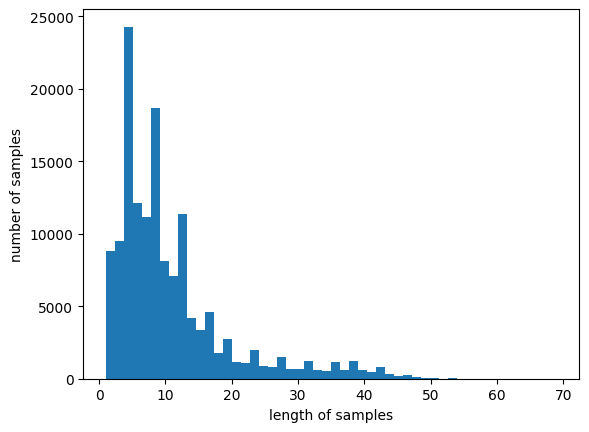

In [74]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 샘플의 길이차이가 많으므로 샘플 길이를 30으로 맞춤
- 샘플길이가 일정 수 이하인 비율 계산하는 함수 작성 후 확인하고 진행

In [75]:
# 샘플길이가 파라미터 max_len 이하인 샘플 비율 확인 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [76]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31729473938724


In [77]:
# 전체 데이터의 길이는 30으로 맞춘다. 패딩 진행
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [78]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  50,
       454,  16, 260, 659])

## 학습 데이터 전처리 완성

<hr/>

# 2. LSTM으로 네이버 영화 리뷰 감성 분류하기

In [79]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### 조기종료 및 체크포인트 결정

### EarlyStopping
- mode : 관찰 항목에 대해 개선이 없다고 판단하기 위한 기준을 지정
    - 예를 들어 관찰 항목이 ‘val_loss’인 경우에는 감소되는 것이 멈출 때 종료되어야 하므로, ‘min’으로 설정
    - auto : 관찰하는 이름에 따라 자동으로 지정
    - min : 관찰하고 있는 항목이 감소되는 것을 멈출 때 종료
    - max : 관찰하고 있는 항목이 증가되는 것을 멈출 때 종료

In [80]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./model/best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

### 모델 구성

In [81]:
embedding_dim=100 #1개 단어에 대한 밀집벡터 사이즈
hidden_units=128 #LSTM의 뉴런 수

In [82]:
model=Sequential()
model.add(Embedding(vocab_size,embedding_dim ))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

In [83]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/20
1809/1810 [============================>.] - ETA: 0s - loss: 0.3899 - acc: 0.8231
Epoch 1: val_acc improved from -inf to 0.84080, saving model to ./model\best_model.h5
1810/1810 [==============================] - 20s 9ms/step - loss: 0.3899 - acc: 0.8231 - val_loss: 0.3573 - val_acc: 0.8408
Epoch 2/20
1810/1810 [==============================] - ETA: 0s - loss: 0.3279 - acc: 0.8579
Epoch 2: val_acc improved from 0.84080 to 0.85569, saving model to ./model\best_model.h5
1810/1810 [==============================] - 14s 8ms/step - loss: 0.3279 - acc: 0.8579 - val_loss: 0.3360 - val_acc: 0.8557
Epoch 3/20
1805/1810 [============================>.] - ETA: 0s - loss: 0.3029 - acc: 0.8715
Epoch 3: val_acc improved from 0.85569 to 0.85824, saving model to ./model\best_model.h5
1810/1810 [==============================] - 14s 8ms/step - loss: 0.3030 - acc: 0.8714 - val_loss: 0.3270 - val_acc: 0.8582
Epoch 4/20
1810/1810 [==============================] - ETA: 0s - loss: 0.2845 - acc:

In [128]:
# loaded_model = load_model('./model/best_model.h5')

In [85]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 5s 3ms/step - loss: 0.3579 - acc: 0.8513

 테스트 정확도: 0.8513


In [ ]:
# word_index 대신 tokenizer 객체 저장
with open('tokenizer.pickle', 'wb') as handle :
    pickle.dump(tokenizer, handle)
    
with open('tokenizer.pickle', 'rb') as handle :
    tokenizer = pickle.load(handle)    

# 3. 리뷰 예측해보기

In [87]:
# 새로운 문장 전처리 및 예측 함수
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [89]:
sentence = input('감성분석할 문장을 입력해 주세요.: ')
sentiment_predict(sentence)

감성분석할 문장을 입력해 주세요.: 이 영화 개꿀잼
1/1 [==============================] - 0s 160ms/step
89.85% 확률로 긍정 리뷰입니다.



C:\Users\USER\AppData\Local\Temp\ipykernel_24164\1715698064.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(model.predict(pad_new)) # 예측
